In [2]:
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.MN.material_NN import *
from NN_library.MN.train_MNN import *
%load_ext autoreload
%autoreload 2

Using device: cuda


In [3]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

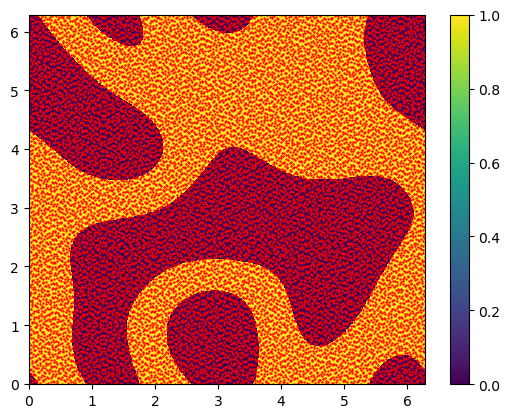

In [4]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

model = gs.Gaussian(dim=2, var=1, len_scale=1.5)

srf = gs.SRF(
    model,
    generator="Fourier",
    period=L,
    mode_no=32,
    seed=2,
)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.floor(srf((x, y))) % 2
    return a

_, x = next(enumerate(loaders['train']))
a_numpy = a_function(x[:,0], x[:,1])
a_torch = torch.tensor(a_numpy, device=dev, dtype=torch.float).view(-1,1)

def A(x):
    return a_torch

Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.5, c='r')

In [5]:
net = Material_NN()
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.001, 'epochs' : 30000, 'dev' : dev, 'name' : f'NN_library/MN/MN_{total_params}'}

Number of parameters: 270


In [6]:
net = load_network(net, args['name']+'_29999', args)
net = net.to(dev)

In [5]:
losses_train = train(net, loaders, args, A)

Epoch: 99 mean train loss:  4.21466960e-05
Epoch: 199 mean train loss:  4.08707900e-05
Epoch: 299 mean train loss:  3.98264357e-05
Epoch: 399 mean train loss:  3.93065645e-05
Epoch: 499 mean train loss:  3.83998814e-05
Epoch: 599 mean train loss:  3.60997706e-05
Epoch: 699 mean train loss:  3.30402789e-05
Epoch: 799 mean train loss:  3.10161360e-05
Epoch: 899 mean train loss:  2.98453619e-05
Epoch: 999 mean train loss:  2.88170836e-05
Epoch: 1099 mean train loss:  2.73045630e-05
Epoch: 1199 mean train loss:  2.48831643e-05
Epoch: 1299 mean train loss:  2.21798529e-05
Epoch: 1399 mean train loss:  1.97576358e-05
Epoch: 1499 mean train loss:  1.76782565e-05
Epoch: 1599 mean train loss:  1.59864855e-05
Epoch: 1699 mean train loss:  1.44895498e-05
Epoch: 1799 mean train loss:  1.32397626e-05
Epoch: 1899 mean train loss:  1.21931161e-05
Epoch: 1999 mean train loss:  1.12852982e-05
Epoch: 2099 mean train loss:  1.04787261e-05
Epoch: 2199 mean train loss:  9.73257232e-06
Epoch: 2299 mean trai

In [7]:
np.save(f'NN_library/training_data/MN_{total_params}', losses_train)

NameError: name 'losses_val' is not defined

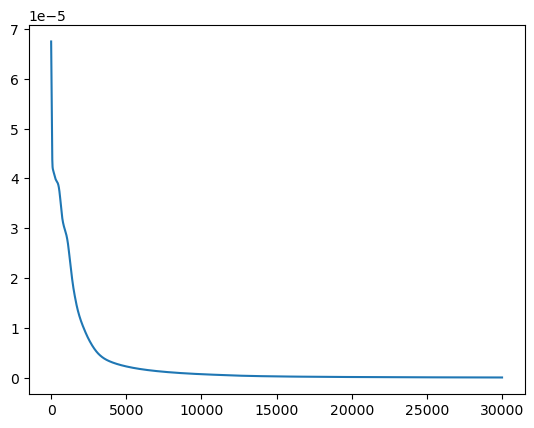

In [ ]:
plt.plot(losses_train)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [7]:
a_numpy = a_function(XY[0].flatten(), XY[1].flatten())
a_torch = torch.tensor(a_numpy, device=dev, dtype=torch.float).view(-1,1)
mat_err = net(grid_data).detach().cpu() - A(grid_data).detach().cpu()

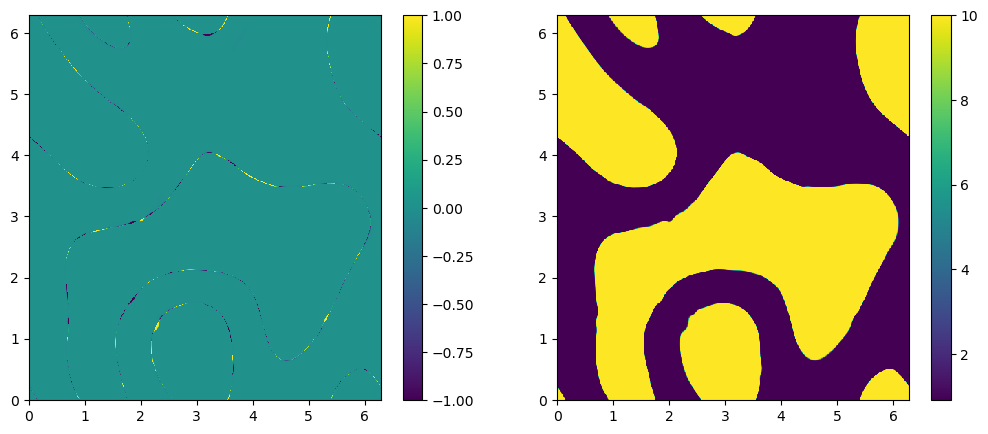

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], mat_err.reshape(N, N))
fig.colorbar(pos1)
pos2 = axs[1].pcolormesh(XY[0], XY[1], 1 / (0.1 + net(grid_data).detach().cpu().reshape(N, N)))
fig.colorbar(pos2)